In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
import random

import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn;
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm

In [ ]:
cmap = plt.get_cmap("inferno")
plt.figure(figsize=(8, 8))
categories = ["healthy", "degraded"]
for category in categories:
    pathlib.Path(os.path.join("img_data", category)).mkdir(parents=True, exist_ok=True)
    if category == "healthy":
        # data_path = "../H_audio"
        data_path = "/content/drive/MyDrive/Conrad/H_audio"
    else:
        # data_path = "../D_audio"
        data_path = "/content/drive/MyDrive/Conrad/D_audio"
        # data_path = "/content/drive/MyDrive/Conrad/H_audio"

    for filename in os.listdir(data_path):
        file_path = os.path.join(data_path, filename)
        y, sr = librosa.load(file_path, mono=True, duration=60)
        plt.specgram(y, NFFT=2048, cmap=cmap, sides="default", mode="default", scale="dB")
        plt.axis("off")
        plt.savefig(os.path.join("img_data", category, f"{filename[:-3].replace('.', '')}.png"))
        plt.clf()

<Figure size 800x800 with 0 Axes>

In [ ]:
img_path = "img_data"

In [ ]:
# Hyperparameters
batch_size = 8
image_size = 224

In [ ]:
# CHANGE THESE TRANSFORMS!!!!!
transform = transforms.Compose([
    transforms.Resize(image_size),
    # transforms.RandomRotation(20),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [ ]:
train_data = ImageFolder(root=img_path, transform=transform)

In [ ]:
def encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder


def decode(data):
    classes = data.classes
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [ ]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoder = encode(data)
        l = encoder[label]

        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

In [ ]:
# class_plot(train_data)

In [ ]:
torch.manual_seed(42)
val_size = int(len(train_data) * 0.2)
train_size = len(train_data) - val_size

In [ ]:
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(122, 30)

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([8, 3, 224, 224])


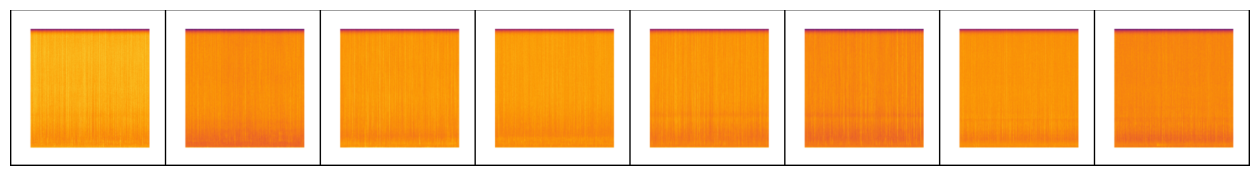

In [ ]:
for images, _ in train_dataloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [ ]:
class Net1(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)

        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)

    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True

    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [ ]:
Net()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 153MB/s]


Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dataloader, device)
val_dl = DeviceDataLoader(val_dataloader, device)

In [ ]:
model = to_device(Net(), device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history = [evaluate(model, val_dl)]

In [ ]:
model.freeze()

In [ ]:
epochs = 30
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.9141, val_score: 0.8259


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.9201, val_score: 0.6429


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.1237, val_score: 0.5938


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.4049, val_score: 0.8705


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.5504, val_score: 0.8393


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.7032, val_score: 0.5312


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.0442, val_score: 0.7366


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.0226, val_score: 0.6339


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.8619, val_score: 0.6696


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9], val_loss: 0.6101, val_score: 0.6741


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10], val_loss: 0.5179, val_score: 0.7723


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.0170, val_score: 0.6696


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12], val_loss: 0.4784, val_score: 0.7679


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.0881, val_score: 0.6116


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14], val_loss: 0.7058, val_score: 0.8036


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15], val_loss: 0.4724, val_score: 0.7589


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16], val_loss: 0.6380, val_score: 0.7366


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17], val_loss: 0.8245, val_score: 0.7679


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18], val_loss: 0.5228, val_score: 0.7679


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19], val_loss: 0.5502, val_score: 0.7723


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20], val_loss: 0.6987, val_score: 0.8348


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21], val_loss: 0.4891, val_score: 0.8304


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22], val_loss: 0.4434, val_score: 0.8616


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23], val_loss: 0.6906, val_score: 0.8036


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24], val_loss: 0.5151, val_score: 0.8036


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25], val_loss: 0.5031, val_score: 0.8348


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26], val_loss: 0.5217, val_score: 0.8348


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27], val_loss: 0.5114, val_score: 0.8348


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28], val_loss: 0.5106, val_score: 0.8348


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29], val_loss: 0.5109, val_score: 0.8348
CPU times: user 17.1 s, sys: 10 s, total: 27.1 s
Wall time: 1min 57s


In [ ]:
# %%time
# history += fit_one_cycle(15, max_lr, model, train_dl, val_dl,
#                          grad_clip=grad_clip,
#                          weight_decay=weight_decay,
#                          opt_func=opt_func)

In [ ]:
# model.unfreeze()

In [ ]:
# %%time
# history += fit_one_cycle(50, max_lr, model, train_dl, val_dl,
#                          grad_clip=grad_clip,
#                          weight_decay=weight_decay,
#                          opt_func=opt_func)

In [ ]:
# %%time
# history += fit_one_cycle(100, max_lr, model, train_dl, val_dl,
#                          grad_clip=grad_clip,
#                          weight_decay=weight_decay,
#                          opt_func=opt_func)